# EXPLORATION 16. 흐린 사진을 선명하게

## IMPORT 및 함수 선언

In [195]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import imageio

def resize(image,size=4):
    image = cv2.resize(
    image,
    dsize=(image.shape[1]//size, image.shape[0]//size)
    )
    return image

def data_load(location):
    hr_image = cv2.imread(os.getenv('HOME') + f'{location}')
    hr_image = cv2.cvtColor(hr_image, cv2.COLOR_BGR2RGB)
    return hr_image

def apply_srgan(image):
    image = tf.cast(image[np.newaxis, ...], tf.float32)
    sr = srgan.predict(image)
    sr = tf.clip_by_value(sr, 0, 255)  # 텐서 값을 지정된 최소값과 최대값으로 자릅니다.
    sr = tf.round(sr)
    sr = tf.cast(sr, tf.uint8)
    return np.array(sr)[0]

def bicubic(lr_image,hr_image):
    bicubic_hr = cv2.resize(lr_image,
    dsize=(hr_image.shape[1], hr_image.shape[0]), # 고해상도 이미지 크기로 설정
    interpolation=cv2.INTER_CUBIC # bicubic 설정
    )
    return bicubic_hr

# 특정 영역을 잘라낼 함수를 정의합니다.
def crop(image, left_top, x=50, y=100):
    return image[left_top[0]:(left_top[0]+x), left_top[1]:(left_top[1]+y), :]

def visual(bicubic,srgan_hr,hr_image):
    left_tops = [(400,100), (350,720), (600,600)]

    images = []
    for left_top in left_tops:
        img1 = crop(bicubic_hr, left_top, 200, 200)
        img2 = crop(srgan_hr , left_top, 200, 200)
        img3 = crop(hr_image, left_top, 200, 200)
        images.extend([img1, img2, img3])

    labels = ["Bicubic", "SRGAN", "HR"] * 3

    plt.figure(figsize=(18,18))
    for i in range(9):
        plt.subplot(3,3,i+1) 
        plt.imshow(images[i])
        plt.title(labels[i], fontsize=30)

In [163]:
train, valid = tfds.load(
    "div2k/bicubic_x4", 
    split=["train","validation"],
    as_supervised=True      # as_supervised=True 옵션을 주면 dict 형태가 아닌 tuple 형태로 데이터를 return 받습니다.
)

for i, (lr, hr) in enumerate(valid):
    if i == 6: break

## 프로젝트 1-1

(500, 900, 3)


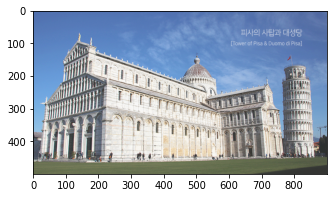

In [165]:
hr_image = data_load('/aiffel/image/tower.jpg')
print(hr_image.shape)

plt.figure(figsize=(6,3))
plt.imshow(hr_image)

(125, 225, 3)


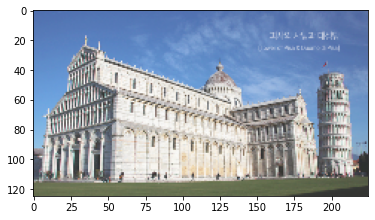

In [166]:
lr_image = resize(hr_image)
print(lr_image.shape)
plt.imshow(lr_image)

In [3]:
model_file = os.getenv('HOME')+'/aiffel/super_resolution/srgan_G.h5'
srgan = tf.keras.models.load_model(model_file)

In [167]:
srgan_hr = apply_srgan(lr_image)

In [168]:
bicubic_hr = bicubic(lr_image,hr_image)

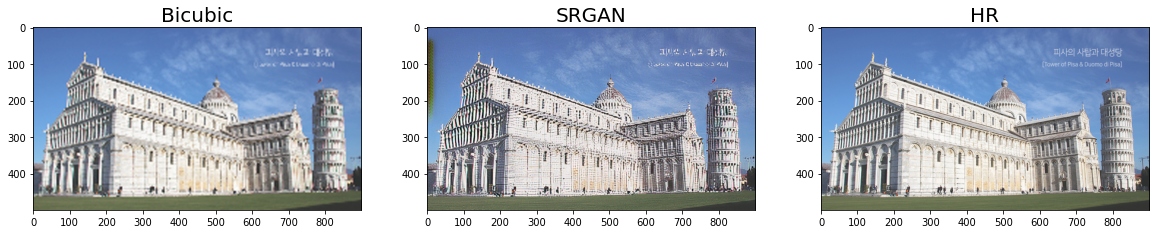

In [169]:
images = [bicubic_hr, srgan_hr, hr_image]
titles = ["Bicubic", "SRGAN", "HR"]

plt.figure(figsize=(20,5))
for i, (image, title) in enumerate(zip(images, titles)):
    plt.subplot(1,3,i+1)
    plt.imshow(image)
    plt.title(title, fontsize=20)


In [170]:
print(bicubic_hr.shape)
print(srgan_hr.shape)
print(hr_image.shape)

(500, 900, 3)
(500, 900, 3)
(500, 900, 3)


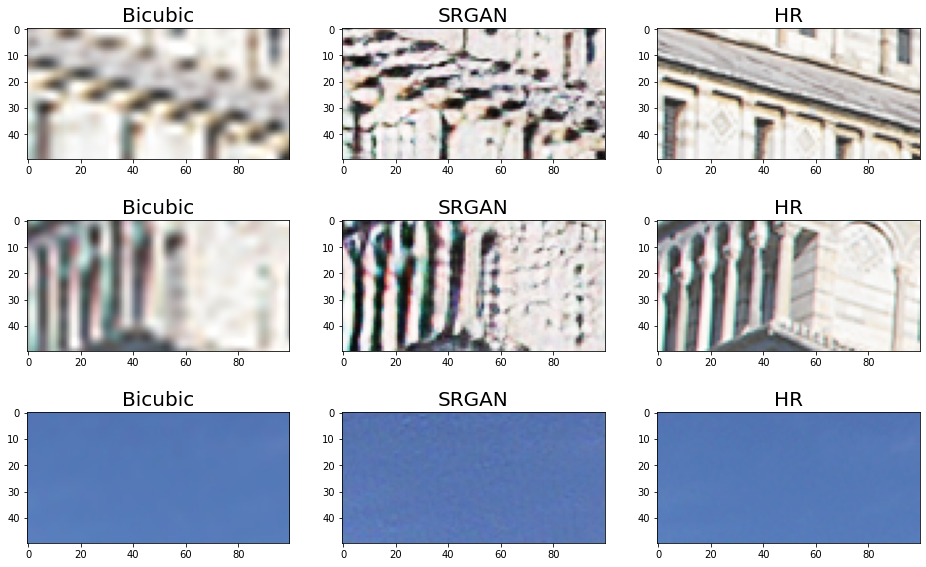

In [171]:
left_tops = [(220,260)] *3 + [(150,120)] *3 + [(10,280)] *3

plt.figure(figsize=(16,10))
for i, (image, left_top, title) in enumerate(zip(images*3, left_tops, titles*3)):
    plt.subplot(3,3,i+1)
    plt.imshow(crop(image, left_top))
    plt.title(title, fontsize=20)


## 프로젝트 1-2

(500, 900, 3)
(83, 150, 3)


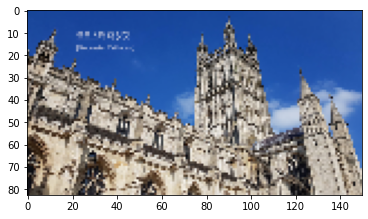

In [175]:
image = data_load('/aiffel/image/tower2.jpg')
print(image.shape)
tower2 = resize(image,size=6)
print(cat2.shape)

plt.imshow(cat2)

In [176]:
srgan_hr = apply_srgan(tower2)

In [177]:
bicubic_hr_image = bicubic(image,tower2)

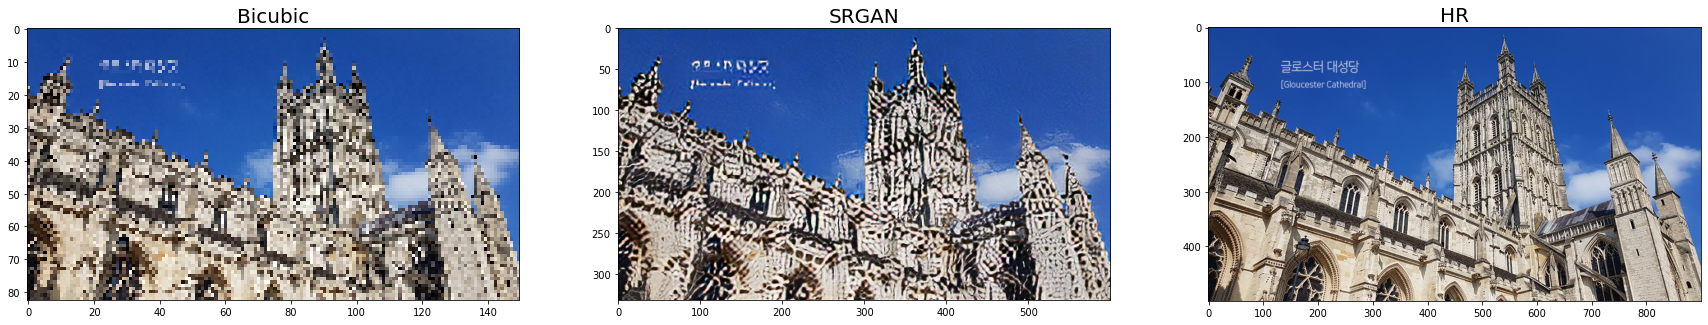

In [178]:
# 시각화
images = [bicubic_hr_image, srgan_hr,image]
titles = ["Bicubic", "SRGAN","HR"]

plt.figure(figsize=(30,10))
for i, (image, title) in enumerate(zip(images, titles)):
    plt.subplot(1,3,i+1)
    plt.imshow(image)
    plt.title(title, fontsize=20)

# 프로젝트 2. SRGAN을 이용해 고해상도 GIF 생성하기

## GIF 파일 불러오기

In [193]:
import cv2

# 다운받은 파일의 경로를 설정해 주세요.
gif = cv2.VideoCapture("/aiffel/aiffel/image/fire_lr.gif")

isTrue = True
frames = []
while isTrue:
    isTrue, frame = gif.read()
    if isTrue:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)
        

print("frame 수 :", len(frames))
print("frame 크기 :", (frames[0].shape))

frame 수 : 14
frame 크기 : (282, 300, 3)


## SRGAN GIF

In [196]:
frames_sr = []
for frame in frames:
    frame_sr = apply_srgan(frame)
    frames_sr.append(frame_sr)
    
imageio.mimsave("srgan.gif", frames_sr)

## Bicubic GIF

In [197]:
frames_bicubic = []
for frame in frames:
    frame_bicubic = cv2.resize(
        frame,
        dsize = (frame.shape[1]*4, frame.shape[0]*4),
        interpolation = cv2.INTER_CUBIC
    )
    frames_bicubic.append(frame_bicubic)
    
imageio.mimsave("bicubic.gif", frames_bicubic)

In [198]:
from IPython.display import Image as show_gif

# SRGAN
https://drive.google.com/file/d/1OGTsqORcbxGctqtnPK8m3aD854Y57aF1/view?usp=sharing
# HR
https://drive.google.com/file/d/17dCViWuzijUzcj8Jc0877MWiY8B_HGay/view?usp=sharing
# Bicubic
https://drive.google.com/file/d/1xLtHphRSll5jbk9YgAq8rIYZt8Y65xV2/view?usp=sharing

회고
- 너무나 힘들다..일반적인 GAN 모델을 처음 접해봤을때 느꼈던 혁신을 다시 한 번 느낄수 있었다.
단순히 화질이 안좋은 드라마,영화를 재작업하는 요소도 분명히 상업적인 가치가 있겠지만 왠지
조금 더 다른곳도 쓰일 수 있겠다는 생각이 들었다.
- 이미지에 경우 확실히 노드에 적혀있는데로 큰 이미지를 사용하지 않으면 이미지 부분에서 오류가 생기는 것을 알 수 있었다.